In [1]:
from sklearn.svm import LinearSVC
from gensim.models import Word2Vec
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
#from abstract import *
from sklearn.datasets import fetch_20newsgroups
from nltk.corpus import stopwords
from sklearn.grid_search import GridSearchCV
import numpy as np
from sklearn.cross_validation import cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import classification_report
import sys



/Users/bhtucker/.virtualenvs/citadel/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/bhtucker/.virtualenvs/citadel/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
categories = ['alt.atheism','rec.sport.baseball','talk.politics.mideast','comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',categories=categories, remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test',categories=categories, remove=('headers', 'footers', 'quotes'))

# Preprocessing 

In [3]:
import string
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import PorterStemmer


def preprocessor(text, stem=False, stop=False, sent=False):
    """
    Tokenize :text use nltk.word_tokenize, optionally:
        stemming tokens if :stem
        removeing stop words if :stop
        joining tokens into one string with whitespace if :sent
    """
    
    # Remove punctuations
    exclude = set(string.punctuation)
    text = ''.join(ch for ch in text if ch not in exclude)
 
    tokens = word_tokenize(text)
    
    if stop:
        stop = stopwords.words('english')
        tokens =[word for word in tokens if word not in stop]
        tokens = [word.lower() for word in tokens]

    if stem:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens]
    
    if sent:
        tokens = ' '.join(tokens)
        
    return tokens
    



In [4]:
from pprint import pprint
pprint(preprocessor(newsgroups_train.data[0], sent=True, stem=True))


u'forgiv ani inaccuraci i delet the origin post isnt thi the same person who wrote the book and wa censur in canada a few year back'



# Using TF-IDF 

In [4]:
from functools import partial
vectorizer = TfidfVectorizer(
    tokenizer=partial(preprocessor, stem=True, stop=True)
    , ngram_range=(1, 3)
    , min_df=3
)  # stem=True, stop=True
le = LabelEncoder()

# Training 
vectors_train = vectorizer.fit_transform(newsgroups_train.data)
labels_train = le.fit_transform(newsgroups_train.target)

# Just for debug quickly reassign labels
X = vectors_train
y = labels_train


In [5]:
nb_classes = len(le.classes_)
svd_dims = 200
print(X.shape)

(2818, 20697)


In [6]:
# from sklearn import metrics
# reload(metrics)
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV

#clf = MultinomialNB(alpha=.01)
clf = svm.LinearSVC(C=1., multi_class='ovr', penalty='l1', dual=False)
# clf.fit(vectors_train, newsgroups_train.target)


# Evaluate using cross validation
cross_val = StratifiedKFold(y, n_folds=2, shuffle=True)

for svm_train, mlp_train in cross_val:
    break

X_svm, y_svm = X[svm_train], y[svm_train]
X_mlp, y_mlp = X[mlp_train], y[mlp_train]
clf.fit(X_svm, y_svm)
y_pred = clf.predict(X_mlp)
print classification_report(le.inverse_transform(y_mlp),le.inverse_transform(y_pred))
print metrics.confusion_matrix(y_pred, y_mlp)


             precision    recall  f1-score   support

          0       0.78      0.77      0.77       240
          1       0.81      0.88      0.84       292
          2       0.76      0.90      0.82       299
          3       0.82      0.73      0.77       297
          4       0.89      0.75      0.81       282

avg / total       0.81      0.81      0.81      1410

[[184   3   6  18  25]
 [ 15 257  10  25  10]
 [ 18  17 268  27  23]
 [ 11  13  11 218  13]
 [ 12   2   4   9 211]]


In [7]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(svd_dims)

X_svd = svd.fit_transform(X)

In [8]:
svm_component = clf.decision_function(X_mlp)


In [9]:
svm_component.shape

(1410, 5)

In [10]:
X_svd[mlp_train].shape

(1410, 200)

In [12]:
full_X_mlp = np.hstack((svm_component, X_svd[mlp_train]))

In [13]:
full_X_mlp.shape

(1410, 205)

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
model = Sequential()
model.add(Dense(512, input_shape=(svd_dims + nb_classes,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))


In [22]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [18]:
from keras.utils import np_utils
y_mlp_cat = np_utils.to_categorical(y_mlp, nb_classes)
y_mlp_cat[0]

array([ 0.,  0.,  0.,  0.,  1.])

In [23]:
model.fit(X_svd[mlp_train], y_mlp_cat,
        nb_epoch=25, batch_size=32,
        verbose=1, validation_split=0.1)

Train on 1269 samples, validate on 141 samples
Epoch 1/25
1269/1269 [==============================] - 0s - loss: 1.0567 - acc: 0.6627 - val_loss: 0.6230 - val_acc: 0.7943
Epoch 2/25
1269/1269 [==============================] - 0s - loss: 0.5867 - acc: 0.7912 - val_loss: 0.5573 - val_acc: 0.7730
Epoch 3/25
1269/1269 [==============================] - 0s - loss: 0.5160 - acc: 0.8172 - val_loss: 0.5378 - val_acc: 0.7943
Epoch 4/25
1269/1269 [==============================] - 0s - loss: 0.4904 - acc: 0.8266 - val_loss: 0.5344 - val_acc: 0.7872
Epoch 5/25
1269/1269 [==============================] - 0s - loss: 0.4511 - acc: 0.8448 - val_loss: 0.5138 - val_acc: 0.8085
Epoch 6/25
1269/1269 [==============================] - 0s - loss: 0.4231 - acc: 0.8487 - val_loss: 0.5113 - val_acc: 0.7801
Epoch 7/25
1269/1269 [==============================] - 0s - loss: 0.4102 - acc: 0.8550 - val_loss: 0.5188 - val_acc: 0.7801
Epoch 8/25
1269/1269 [==============================] - 0s - loss: 0.3843 - ac

In [31]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
def get_compiled_model(input_dims):
    model = Sequential()
    model.add(Dense(512, input_shape=(input_dims,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

no_svm_model = get_compiled_model(svd_dims)

no_svm_model.fit(X_svd[mlp_train], y_mlp_cat,
            nb_epoch=25, batch_size=32,
            verbose=1, validation_split=0.1)

Train on 1269 samples, validate on 141 samples
Epoch 1/25
1269/1269 [==============================] - 0s - loss: 1.5750 - acc: 0.3499 - val_loss: 1.5199 - val_acc: 0.5674
Epoch 2/25
1269/1269 [==============================] - 0s - loss: 1.3616 - acc: 0.6367 - val_loss: 1.1939 - val_acc: 0.7801
Epoch 3/25
1269/1269 [==============================] - 0s - loss: 0.8918 - acc: 0.7770 - val_loss: 0.7484 - val_acc: 0.7730
Epoch 4/25
1269/1269 [==============================] - 0s - loss: 0.5768 - acc: 0.8345 - val_loss: 0.5910 - val_acc: 0.8156
Epoch 5/25
1269/1269 [==============================] - 0s - loss: 0.4308 - acc: 0.8700 - val_loss: 0.5404 - val_acc: 0.8085
Epoch 6/25
1269/1269 [==============================] - 0s - loss: 0.3649 - acc: 0.8842 - val_loss: 0.5119 - val_acc: 0.8298
Epoch 7/25
1269/1269 [==============================] - 0s - loss: 0.3123 - acc: 0.8991 - val_loss: 0.5167 - val_acc: 0.8369
Epoch 8/25
1269/1269 [==============================] - 0s - loss: 0.2813 - ac

In [32]:
mlp_svm_model = get_compiled_model(svd_dims + nb_classes)

mlp_svm_model.fit(full_X_mlp, y_mlp_cat,
            nb_epoch=25, batch_size=32,
            verbose=1, validation_split=0.1)

Train on 1269 samples, validate on 141 samples
Epoch 1/25
1269/1269 [==============================] - 0s - loss: 1.0576 - acc: 0.6698 - val_loss: 0.6221 - val_acc: 0.7730
Epoch 2/25
1269/1269 [==============================] - 0s - loss: 0.5830 - acc: 0.8022 - val_loss: 0.5304 - val_acc: 0.8085
Epoch 3/25
1269/1269 [==============================] - 0s - loss: 0.5176 - acc: 0.8219 - val_loss: 0.5313 - val_acc: 0.8156
Epoch 4/25
1269/1269 [==============================] - 0s - loss: 0.4820 - acc: 0.8322 - val_loss: 0.5193 - val_acc: 0.8156
Epoch 5/25
1269/1269 [==============================] - 0s - loss: 0.4523 - acc: 0.8385 - val_loss: 0.5306 - val_acc: 0.7730
Epoch 6/25
1269/1269 [==============================] - 0s - loss: 0.4288 - acc: 0.8377 - val_loss: 0.5653 - val_acc: 0.7730
Epoch 7/25
1269/1269 [==============================] - 0s - loss: 0.4125 - acc: 0.8574 - val_loss: 0.4935 - val_acc: 0.8014
Epoch 8/25
1269/1269 [==============================] - 0s - loss: 0.3836 - ac

In [33]:
vectors_test = vectorizer.transform(newsgroups_test.data)

In [34]:
# no svm confusion results
svd_test = svd.transform(vectors_test)
no_svm_pred = no_svm_model.predict_classes(svd_test)

1875/1875 [==============================] - 0s     


In [37]:
y_test = le.inverse_transform(newsgroups_test.target)

In [38]:
# no_svm_pred = pred
print classification_report(y_test, no_svm_pred)

             precision    recall  f1-score   support

          0       0.74      0.72      0.73       319
          1       0.88      0.84      0.86       389
          2       0.79      0.92      0.85       397
          3       0.84      0.79      0.82       394
          4       0.83      0.81      0.82       376

avg / total       0.82      0.82      0.82      1875



In [39]:
# svd_test = svm_test
svm_test = clf.decision_function(vectors_test)
full_X_mlp_test = np.hstack([svm_test, svd_test])
mlp_svm_pred = mlp_svm_model.predict_classes(full_X_mlp_test)
print classification_report(y_test, mlp_svm_pred)

1875/1875 [==============================] - 0s     
             precision    recall  f1-score   support

          0       0.69      0.72      0.71       319
          1       0.85      0.81      0.83       389
          2       0.78      0.92      0.85       397
          3       0.82      0.79      0.81       394
          4       0.85      0.74      0.79       376

avg / total       0.80      0.80      0.80      1875



1875/1875 [==============================] - 0s     


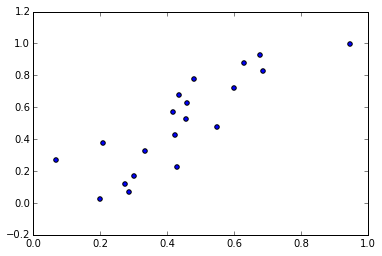

In [47]:
%matplotlib inline
from matplotlib.pylab import plt
from sklearn.calibration import calibration_curve
mlp_svm_test_probas = mlp_svm_model.predict_proba(full_X_mlp_test)
predicted_class_proba = np.choose(mlp_svm_pred, mlp_svm_test_probas.T)
correct_pred = [a == b for a, b in zip(y_test, mlp_svm_pred)]
plt.scatter(*calibration_curve(correct_pred, predicted_class_proba, n_bins=20, normalize=True))

1875/1875 [==============================] - 0s     


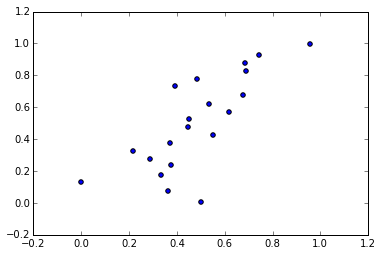

In [49]:
show_multiclass_calibration(no_svm_model, svd_test, y_test)

In [48]:
def show_multiclass_calibration(model, x_test, y_test):
    test_probas = model.predict_proba(x_test)
    test_pred = model.predict_classes(x_test)
    predicted_class_proba = np.choose(test_pred, test_probas.T)
    correct_pred = [a == b for a, b in zip(y_test, test_pred)]
    plt.scatter(*calibration_curve(correct_pred, predicted_class_proba, n_bins=20, normalize=True))

In [27]:
show_multiclass_calibration

1875

In [7]:
clf = svm.LinearSVC(C=1., multi_class='ovr')
calibrated = CalibratedClassifierCV(clf, cv=2, method='isotonic')
calibrated.fit(vectors_train, newsgroups_train.target)
vectors_test = vectorizer.transform(newsgroups_test.data)
pred = calibrated.predict(vectors_test)


print classification_report(le.inverse_transform(newsgroups_test.target),le.inverse_transform(pred))
# stem and stop 0.82 (.78 - .86)
# no stem or stop .81

# avg / total       0.83      0.83      0.83      1875


             precision    recall  f1-score   support

          0       0.76      0.74      0.75       319
          1       0.88      0.89      0.89       389
          2       0.84      0.92      0.88       397
          3       0.83      0.82      0.83       394
          4       0.90      0.82      0.86       376

avg / total       0.84      0.84      0.84      1875



In [88]:
# classification report filtering 'uncertain' results:
pred = calibrated.predict(vectors_test)
probas = calibrated.predict_proba(vectors_test)
more_certain_mask = np.choose(pred, probas.T) > .8
print classification_report(
    newsgroups_test.target[more_certain_mask],
    pred[more_certain_mask]
)

             precision    recall  f1-score   support

          0       0.96      0.95      0.96       169
          1       0.98      0.99      0.98       282
          2       0.99      1.00      0.99       271
          3       0.98      0.98      0.98       242
          4       0.98      0.97      0.97       221

avg / total       0.98      0.98      0.98      1185



In [20]:
calibrated = CalibratedClassifierCV(clf, cv='prefit', method='isotonic')
calibrated.fit(vectors_train, newsgroups_train.target)
pred = calibrated.predict(vectors_test)
# le.inverse_transform(newsgroups_test.target)

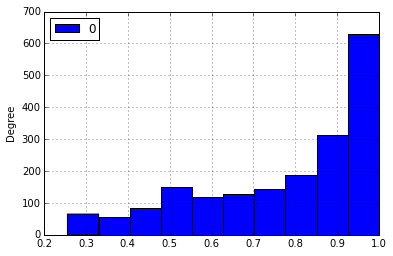

In [50]:
pd.DataFrame(np.choose(pred, probas.T)).plot(kind='hist')

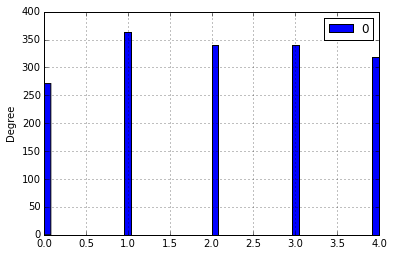

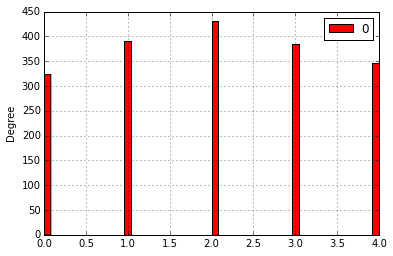

In [58]:
pd.DataFrame(pred[np.choose(pred, probas.T) > .5]).plot(kind='hist', bins=50)
pd.DataFrame(pred).plot(kind='hist', bins=50, color='r')

In [63]:
newsgroups_test.target[more_certain_mask].shape

/Users/bhtucker/.virtualenvs/citadel/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  if __name__ == '__main__':


(1875, 1)

In [73]:
# np.select([more_certain_mask], [newsgroups_test.target]).shape
np.select([more_certain_mask], [newsgroups_test.target.reshape((1875, 1))]).shape
# ?np.select

(1875, 1)

In [33]:
probaas[((probaas > .2) & (probaas < .8))]

array([ 0.76486329,  0.23513671,  0.47792063,  0.36109558,  0.56119999,
        0.43880001,  0.28816987,  0.61476239,  0.2519685 ,  0.7480315 ,
        0.75704802,  0.24295198,  0.43863873,  0.56136127,  0.30468172,
        0.64721064,  0.2519685 ,  0.7480315 ,  0.58323544,  0.4091495 ,
        0.5       ,  0.5       ,  0.60440905,  0.39559095,  0.74343508,
        0.25656492,  0.37583082,  0.62416918,  0.49043049,  0.31067897,
        0.73846154,  0.26153846,  0.2519685 ,  0.7480315 ,  0.2519685 ,
        0.7480315 ,  0.30835118,  0.69164882,  0.35548898,  0.64451102,
        0.57421218,  0.42578782,  0.75813067,  0.24186933,  0.49913738,
        0.50086262,  0.34944306,  0.65055694,  0.28816987,  0.61476239,
        0.68058109,  0.31941891,  0.6613488 ,  0.2342277 ,  0.36000942,
        0.61781894,  0.78271476,  0.21728524,  0.49293057,  0.50706943,
        0.30835118,  0.69164882,  0.42678106,  0.57321894,  0.46139353,
        0.53860647,  0.72477082,  0.27522918,  0.56962025,  0.43

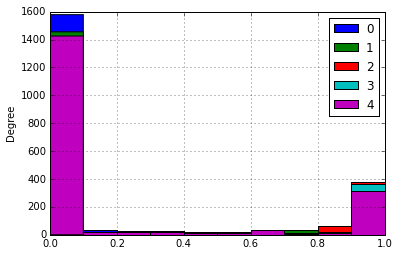

In [24]:
%matplotlib inline
import pandas as pd
pd.DataFrame(probaas).plot(kind='hist')

# Using Doc2Vec

In [ ]:
#Preprocessing for Doc2Vec 

newsgroups_train_tokens = map(partial(preprocessor, stop=True), newsgroups_train.data)
newsgroups_test_tokens = map(partial(preprocessor, stop=True), newsgroups_test.data)

In [ ]:
from gensim.models import Doc2Vec
import gensim.models.doc2vec

from collections import OrderedDict
import multiprocessing
from gensim.models.doc2vec import TaggedDocument
import sys

cores = multiprocessing.cpu_count()
assert gensim.models.doc2vec.FAST_VERSION > -1, "this will be painfully slow otherwise"


In [ ]:
from collections import namedtuple
import nltk
from gensim.models.doc2vec import LabeledSentence


In [ ]:
?LabeledSentence

In [ ]:
from collections import namedtuple
import nltk
from gensim.models.doc2vec import LabeledSentence


def convert_newsgroup(docs, split):
    """
    Generate doc2vec.LabeledSentence instances from dataset :docs
    with train/test indicator :split
    """
    for i,v in enumerate(docs):
        label = '%s_%s' % (split, i)
        yield LabeledSentence(v, [label])

test_docs = list(convert_newsgroup(newsgroups_test_tokens, 'test'))
train_docs = list(convert_newsgroup(newsgroups_train_tokens, 'train'))

all_newsgroup_documents = [train_docs, test_docs]

doc_list = all_newsgroup_documents[:]  # for reshuffling per pass

print('%d doc sets: %d train, %d test' % (len(doc_list), len(train_docs), len(test_docs)))


### Set Up Doc2Vec

In [ ]:
#Doc2Vec(dm=0, dm_concat=1, size=300, window=5, negative=5, hs=0, min_count=3, workers=cores)
#Doc2Vec(dm=0, dm_mean=1, size=300, window=5, negative=5, hs=0, min_count=3, workers=cores),

dbow_model = Doc2Vec(dm=0, dm_concat=0, sample=1e-5, size=288, window=5, negative=5, hs=0, min_count=2, workers=cores)
# dm_model =  Doc2Vec(dm=1, dm_mean=1, sample=1e-5, size=300, window=10, negative=5, hs=0, min_count=2, workers=cores)

# TODO speed setup by sharing results of 1st model's vocabulary scan
# dbow_model.load_word2vec_format('/home/skillachie/Downloads/GoogleNews-vectors-negative300.bin.gz', binary=True)
dbow_model.build_vocab(train_docs)  # PV-DM/concat requires one special NULL word so it serves as template

# dm_model.load_word2vec_format('/home/skillachie/Downloads/GoogleNews-vectors-negative300.bin.gz', binary=True)
# dm_model.build_vocab(all_newsgroup_documents)  # PV-DM/concat requires one special NULL word so it serves as template



# Models to evaluate
#simple_models = [
 
    # PV-DBOW  0.86 with Stem & hs=0
    #Doc2Vec(dm=0, dm_concat=1,sample=1e-5, size=300, window=5, negative=5, hs=0, min_count=2, workers=cores),
    
    #
    #Doc2Vec(dm=0, dm_mean=1, sample=1e-5,size=300, window=5, negative=5, hs=0, min_count=2, workers=cores),
    
    
    #Doc2Vec(dm=0, size=300, negative=5, hs=0, min_count=1, workers=cores),
    
    # PV-DM w/average No good 0.84
    #Doc2Vec(dm=1, dm_mean=1, sample=1e-5, size=300, window=10, negative=5, hs=0, min_count=2, workers=cores),
    
    # PV-DM w/sum
    #Doc2Vec(dm=1, dm_mean=0, size=100, window=10, negative=5, hs=0, min_count=2, workers=cores),
#]

# speed setup by sharing results of 1st model's vocabulary scan
#simple_models[0].load_word2vec_format('/home/skillachie/Downloads/GoogleNews-vectors-negative300.bin.gz', binary=True)
#simple_models[0].build_vocab(all_newsgroup_documents)  # PV-DM/concat requires one special NULL word so it serves as template


#print(simple_models[0])

#for model in simple_models[1:]:
    #model.reset_from(simple_models[0])
#    model.load_word2vec_forma('/home/skillachie/nlpArea51/doc2vec/GoogleNews-vectors-negative300.bin', binary=True)
#    model.build_vocab(all_newsgroup_documents)
#    print(model)

#models_by_name = OrderedDict((str(model), model) for model in simple_models)

In [ ]:
def d2v(train_docs):
    model = Doc2Vec(dm=1, dm_concat=0, sample=1e-5, size=288, window=5, negative=5, hs=1, min_count=2, workers=cores)
# dm_model =  Doc2Vec(dm=1, dm_mean=1, sample=1e-5, size=300, window=10, negative=5, hs=0, min_count=2, workers=cores)

# TODO speed setup by sharing results of 1st model's vocabulary scan
# dbow_model.load_word2vec_format('/home/skillachie/Downloads/GoogleNews-vectors-negative300.bin.gz', binary=True)
    model.build_vocab(train_docs)  # PV-DM/concat requires one special NULL word so it serves as template
    return model
dm = d2v(train_docs)

In [ ]:
vecs = extract_vectors(dm, train_docs)

In [ ]:
dm.vocab['fish']

In [ ]:
dm.n_similarity

In [ ]:
tokens

In [ ]:
# vecs[0]
# dm.vocab
doc_label = train_docs[0].tags[0]
# doc_vector = model.docvecs[doc_label]
# vectors_list.append(doc_vector)

In [ ]:
le.(labels_train[0])

In [ ]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
dbow_dmm_model = ConcatenatedDoc2Vec([dbow_model, dm_model])
#models_by_name['dbow+dmc'] = ConcatenatedDoc2Vec([simple_models[1], simple_models[0]])

### Prediction and Evaluation

### Training

Why is bulk training done with all the  docs from train, test,  and dev ? Compared to other methods training is only done on the training dataset 

In [ ]:
from collections import defaultdict
best_error = defaultdict(lambda: 1.)  # to selectively-print only best errors achieved

In [ ]:

def extract_vectors(model, docs):
    """
    Get Vectors From Word2Vec
    """
    vectors_list = []
    
    for doc_no in range(len(docs)):
        doc_label = docs[doc_no].tags[0]
        doc_vector = model.docvecs[doc_label]
        vectors_list.append(doc_vector)
        
    return vectors_list

# TODO inferred vectors

def get_infer_vectors(model, docs):
    
    vecs = []
    for doc in docs:
        vecs.append(model.infer_vector(doc.words))
    return vecs
    
    

In [ ]:
# dbow_model.alpha, dbow_model.min_alpha = 0.025, 0.025
# dbow_model.train(train_docs)
?dbow_model.train

In [ ]:
from random import shuffle

train_docs_ = list(train_docs)
for gen in range(1):
    alpha, min_alpha, passes = (0.025, 0.001, 20)
    alpha_delta = (alpha - min_alpha) / passes
    for epoch in range(passes):
        shuffle(train_docs_)

        #for name, train_model in models_by_name.items():

        #Train
        print alpha
        dm.alpha, dm.min_alpha = alpha, alpha
        print(dm.train(train_docs_))

    #     dm_model.alpha, dm_model.min_alpha = alpha, alpha
    #     dm_model.train(doc_list)


    #     dbow_dmm_model.alpha, dbow_dmm_model.min_alpha = alpha, alpha
    #     dbow_dmm_model.train(doc_list)


        alpha -= alpha_delta


In [ ]:

import numpy as np
import statsmodels.api as sm
from random import sample
def logistic_predictor_from_data(train_targets, train_regressors):
#     import ipdb; ipdb.set_trace()
    logit = sm.Logit(train_targets, train_regressors)
    predictor = logit.fit(disp=0)
    #print(predictor.summary())
    return predictor

def error_rate_for_model(test_model, train_set, test_set, infer=False, infer_steps=3, infer_alpha=0.1, infer_subsample=0.1):
    """Report error rate on test_doc sentiments, using supplied model and train_docs"""

    train_targets, train_regressors = [float(v == 4) for v in labels_train], list(test_model.docvecs)
    train_regressors = sm.add_constant(train_regressors)
    predictor = logistic_predictor_from_data(train_targets, train_regressors)

    test_data = test_set
    if infer:
        if infer_subsample < 1.0:
            test_data = sample(test_data, int(infer_subsample * len(test_data)))
        test_regressors = [test_model.infer_vector(doc.words, steps=infer_steps, alpha=infer_alpha) for doc in test_data]
    else:
        test_regressors = [test_model.docvecs[doc.tags[0]] for doc in test_docs]
    test_regressors = sm.add_constant(test_regressors)
    
    # predict & evaluate
    test_predictions = predictor.predict(test_regressors)
    corrects = sum(np.rint(test_predictions) == [doc.sentiment for doc in test_data])
    errors = len(test_predictions) - corrects
    error_rate = float(errors) / len(test_predictions)
    return (error_rate, errors, len(test_predictions), predictor)

error_rate_for_model(dm, train_docs, test_docs)

In [ ]:
sm.Logit([float(v == 2) for v in labels_train], list(dm.docvecs)).fit()
# type(dm.docvecs[0])

In [ ]:
len(set(labels_train))

In [ ]:
# error_rate_for_model(dm, train_docs, test_docs)
train_docs[0]

In [ ]:
# tokens = (
#     'god belief graphic reason '
#     'pitch hitter clutch heretic '
#     'congress hardware vote conservative '
#     'shuttle launch fishing solar '
# ).split()
# for i in range(len(tokens)):
#     tup = (tokens[i], tokens[i+1])
#     print(tup)
#     print(dm.n_similarity(*tup), untrained_model.n_similarity(*tup))


In [ ]:
import random
from IPython.display import HTML
# pick a random word with a suitable number of occurences
# while True:
#     word = random.choice(dm.index2word)
#     if dm.vocab[word].count > 10:
#         break

# # or uncomment below line, to just pick a word from the relevant domain:

model = untrained_model
word = 'terrorists'
similars_per_model = [str(model.most_similar(word, topn=20)).replace('), ','),<br>\n')]
similar_table = ("<table><tr><th>" +
    "</th><th>".join([str(model), word]) + 
    "</th></tr><tr><td>" +
    "</td><td>".join(similars_per_model) +
    "</td></tr></table>")
print("most similar words for '%s' (%d occurences)" % (word, model.vocab[word].count))
HTML(similar_table)

In [ ]:
similars_per_model

In [ ]:
%matplotlib inline
import seaborn as sns

from sklearn.metrics import pairwise_distances 
mat = np.array([
    [
    dm.similarity(a, b)
    for a in selection
]
    for b in selection
    ])
# distmat = pairwise_distances(np.array(dm.vocab.keys()), np.array(dm.vocab.keys()), metric=dm.similarity)




In [ ]:
selection  = dm.vocab.keys()[:100]

In [ ]:
list(selection)

In [ ]:
print([
        w
#         int(w.index)
        for (k, w) in dm.vocab.iteritems()
       if k in {'heaven', 'hell', 'gospel', 'sharks', 'arizona', 'indiana'}      
#         and
#         if ix < 100][0])
        ])

In [ ]:
focus = [
 u'woods',
 u'katyusha',
 u'verses',
 u'hanging',
 u'cyprus',
 'outfielders',
 'specialist'
        ]
ixs = [selection.index(w)
       for w in focus]
sns.heatmap(mat[:, ixs][ixs, :], xticklabels=focus, yticklabels=focus)


In [ ]:
focus = [
 u'woods',
 u'katyusha',
 u'verses',
 u'hanging',
 u'cyprus',
 'outfielders',
 'specialist'
        ]
ixs = [selection.index(w)
       for w in focus]
sns.heatmap(mat[:, ixs][ixs, :], xticklabels=focus, yticklabels=focus)


In [ ]:
focus = [
 u'woods',
 u'katyusha',
 u'verses',
 u'hanging',
 u'cyprus',
 'outfielders',
 'specialist'
        ]
ixs = [selection.index(w)
       for w in focus]
sns.heatmap(mat[:, ixs][ixs, :], xticklabels=focus, yticklabels=focus)


In [ ]:
focus = [
'jihad',
 u'shouting',        
 u'aggression',
 u'marching'
        ]
ixs = [selection.index(w)
       for w in focus]
sns.heatmap(mat[:, ixs][ixs, :], xticklabels=focus, yticklabels=focus)


In [ ]:
focus = [
'jihad',
 u'shouting',        
 u'aggression',
 u'marching'
        ]
ixs = [selection.index(w)
       for w in focus]
sns.heatmap(mat[:, ixs][ixs, :], xticklabels=focus, yticklabels=focus)


In [ ]:
"""
god belief graphic reason
graphic
graphic
pitch hitter clutch heretic
clutch
clutch
congress hardware vote conservative
congress
congress
shuttle launch fishing solar
fishing
fishing
"""

# categories = ['alt.atheism','rec.sport.baseball','talk.politics.mideast','comp.graphics', 'sci.space']
untrained_model = Doc2Vec(dm=0, dm_concat=0, sample=1e-5, size=48, window=5, negative=5, hs=0, min_count=2, workers=cores)
untrained_model.build_vocab(train_docs)
for sample in [
    'god belief graphic reason',
    'pitch hitter clutch heretic',
    'congress hardware vote conservative',
    'shuttle launch fishing solar'
]:
    print(sample)
    print(untrained_model.doesnt_match(sample.split()))
    print(dm.doesnt_match(sample.split()))    
# dbow_model.doesnt_match('god belief graphic reason'.split())
# newsgroups_train.filenames



In [ ]:
#Evaluation
train_vectors = extract_vectors(dm, train_docs)
test_vectors = get_infer_vectors(dm, test_docs)


#model = LinearSVC()
#penalties = np.array([0.001,0.002,0.003,0.004,0.005,0.007,0.008,0.009,0.01,0.05,0.04,0.03,0.02])
#grid = GridSearchCV(estimator=model ,n_jobs=7,param_grid=dict(C=penalties))
#grid.fit(train_vectors, newsgroups_train.target)
        
# summarize the results of the grid search
#print(grid.best_score_)
#print(grid.best_estimator_.C)

#clf = LinearSVC(C=0.009)
clf = LinearSVC(C=0.0025)
clf.fit(train_vectors, newsgroups_train.target)

predDoc = clf.predict(test_vectors)
        
print classification_report(le.inverse_transform(newsgroups_test.target), le.inverse_transform(predDoc))

# avg / total       0.77      0.76      0.76      1875
# avg / total       0.78      0.76      0.76      1875

In [ ]:
print classification_report(le.inverse_transform(newsgroups_train.target), le.inverse_transform(clf.predict(train_vectors)))